# Uncovering Stock Market Trends: A Statistical Exploration and Predictive Analysis

COMPSCI 216: Everything Data

Group Members (listed in the alphabetic order of the last name):
- Xin Jiang (xj56)
- Yunheng Wang (yw568)
- Ziyue Yin (zy166)
- Yitong Zhou (yz814)

# Code File 01: Value-at-Risk and Expected Shortfall Estimation Using Gibbs Sampling

## Preparation
Here, we import necessary packages and download the Dow Jones Index Data from Yahoo Finance.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
symbol = '^DJI'  # Ticker symbol for Dow Jones Industrial Average
data = yf.download(symbol, start='2000-01-01', end='2016-07-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


To avoid future obstacles, we check missing values and drop the `NA` values.

In [3]:
data.dropna(inplace=True)

We can now take a look at the dataset as a whole.

In [4]:
data

Price,Close,High,Low,Open,Volume
Ticker,^DJI,^DJI,^DJI,^DJI,^DJI
Date,,,,,
2000-01-03,11357.509766,11522.009766,11305.690430,11501.849609,169750000
2000-01-04,10997.929688,11350.059570,10986.450195,11349.750000,178420000
2000-01-05,11122.650391,11215.099609,10938.669922,10989.370117,203190000
2000-01-06,11253.259766,11313.450195,11098.450195,11113.370117,176550000
2000-01-07,11522.559570,11528.139648,11239.919922,11247.059570,184900000
...,...,...,...,...,...
2016-06-24,17400.750000,17946.630859,17356.339844,17946.630859,239000000
2016-06-27,17140.240234,17355.210938,17063.080078,17355.210938,138740000


## Daily Log Returns

Price              Close          High           Low          Open     Volume  \
Ticker              ^DJI          ^DJI          ^DJI          ^DJI       ^DJI   
Date                                                                            
2000-01-04  10997.929688  11350.059570  10986.450195  11349.750000  178420000   
2000-01-05  11122.650391  11215.099609  10938.669922  10989.370117  203190000   
2000-01-06  11253.259766  11313.450195  11098.450195  11113.370117  176550000   
2000-01-07  11522.559570  11528.139648  11239.919922  11247.059570  184900000   
2000-01-10  11572.200195  11638.280273  11532.480469  11532.480469  168180000   

Price      Log_Return  
Ticker                 
Date                   
2000-01-04  -0.032172  
2000-01-05   0.011277  
2000-01-06   0.011674  
2000-01-07   0.023649  
2000-01-10   0.004299  


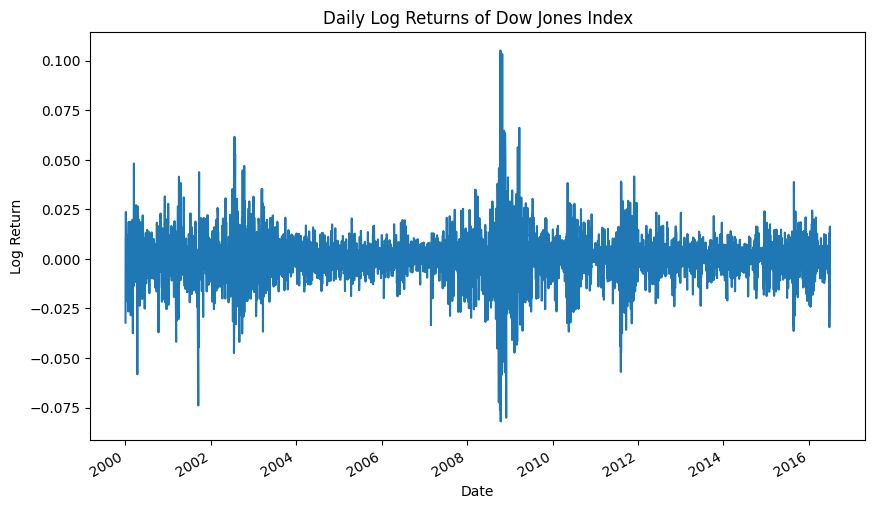

In [5]:
# Calculate daily returns and transform them to log returns
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))

# Drop NaN values resulting from shift operation
data.dropna(inplace=True)

# Display the first few rows of the cleaned data with daily returns
print(data.head())

# Plotting the log returns
data['Log_Return'].plot(figsize=(10, 6))
plt.title('Daily Log Returns of Dow Jones Index')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

Descriptive Statistics for Log Returns:
count    4149.000000
mean        0.000110
std         0.011798
min        -0.082005
25%        -0.005149
50%         0.000446
75%         0.005713
max         0.105083
dtype: float64
Skewness: -0.07313802603223332
Kurtosis: 7.85265098346364
Shapiro-Wilk Test for Normality:
Statistic=0.9209569360577492, P-value=3.269744820093299e-42


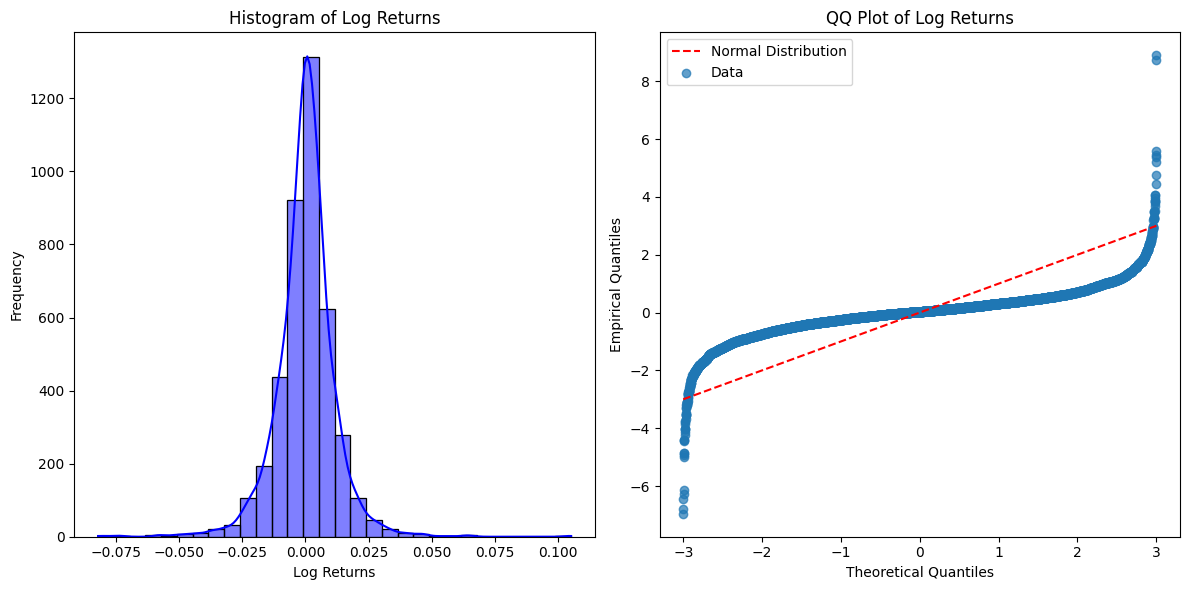

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, norm

# Assume `log_returns` contains the log returns of Dow Jones index
log_returns = data['Log_Return'].values
log_returns_series = pd.Series(log_returns)

# Basic statistics
print("Descriptive Statistics for Log Returns:")
print(log_returns_series.describe())

# Check for skewness and kurtosis
skewness = log_returns_series.skew()
kurtosis = log_returns_series.kurtosis()
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

# Test for normality
stat, p_value = shapiro(log_returns)
print(f"Shapiro-Wilk Test for Normality:\nStatistic={stat}, P-value={p_value}")

# Visualization
plt.figure(figsize=(12, 6))

# Plot histogram with KDE
plt.subplot(1, 2, 1)
sns.histplot(log_returns, kde=True, bins=30, color='blue')
plt.title("Histogram of Log Returns")
plt.xlabel("Log Returns")
plt.ylabel("Frequency")

# QQ plot for normality check
plt.subplot(1, 2, 2)
norm_theoretical = np.linspace(-3, 3, len(log_returns))
norm_actual = np.sort((log_returns - log_returns.mean()) / log_returns.std())
plt.plot(norm_theoretical, norm_theoretical, color="red", linestyle="--", label="Normal Distribution")
plt.scatter(norm_theoretical, norm_actual, alpha=0.7, label="Data")
plt.title("QQ Plot of Log Returns")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Empirical Quantiles")
plt.legend()

plt.tight_layout()
plt.show()

## Gibbs Sampling for Parameter Estimation

In [7]:
import numpy as np
from scipy.stats import invgamma, norm

# Hyperparameters for priors
mu_prior_mean = 0        # Mean for mu prior
mu_prior_variance = 1000 # Variance for mu prior

alpha_prior = 0.1  # Shape parameter for InverseGamma (sigma2 prior)
beta_prior = 0.1   # Scale parameter for InverseGamma (sigma2 prior)

# Gibbs sampling parameters
num_samples = 1000  # Total number of samples
burn_in = 100       # Number of burn-in samples to discard

# Initialize variables
mu_samples = []
sigma2_samples = []

# Initial values
current_mu = 0
current_sigma2 = 1

# Replace 'data' and 'Log_Return' with your DataFrame/column names as needed
log_returns = data['Log_Return'].values

for _ in range(num_samples):
    # Sample mu from the conditional posterior
    mu_posterior_variance = 1.0 / (len(log_returns) / current_sigma2 + 1.0 / mu_prior_variance)
    mu_posterior_mean = mu_posterior_variance * (
        np.sum(log_returns) / current_sigma2 + mu_prior_mean / mu_prior_variance
    )
    current_mu = norm.rvs(mu_posterior_mean, np.sqrt(mu_posterior_variance))
    mu_samples.append(current_mu)

    # Sample sigma2 from the conditional posterior
    alpha_post = alpha_prior + len(log_returns) / 2.0
    beta_post = beta_prior + np.sum((log_returns - current_mu) ** 2) / 2.0
    current_sigma2 = invgamma.rvs(alpha_post, scale=beta_post)
    sigma2_samples.append(current_sigma2)

# Discard burn-in samples
mu_samples_burned = mu_samples[burn_in:]
sigma2_samples_burned = sigma2_samples[burn_in:]

# Estimated parameters after burn-in
estimated_mu = np.mean(mu_samples_burned)
estimated_sigma2 = np.mean(sigma2_samples_burned)

print(f"Estimated Mean (mu) after burn-in: {estimated_mu}")
print(f"Estimated Variance (sigma^2) after burn-in: {estimated_sigma2}")

# 95% credible intervals (based on posterior samples after burn-in)
mu_ci = np.percentile(mu_samples_burned, [2.5, 97.5])
sigma2_ci = np.percentile(sigma2_samples_burned, [2.5, 97.5])

print(f"95% Credible Interval for mu: {mu_ci}")
print(f"95% Credible Interval for sigma^2: {sigma2_ci}")

Estimated Mean (mu) after burn-in: 0.00011454297635996819
Estimated Variance (sigma^2) after burn-in: 0.0001874074353929272
95% Credible Interval for mu: [-0.00027857  0.00050109]
95% Credible Interval for sigma^2: [0.00018004 0.00019498]


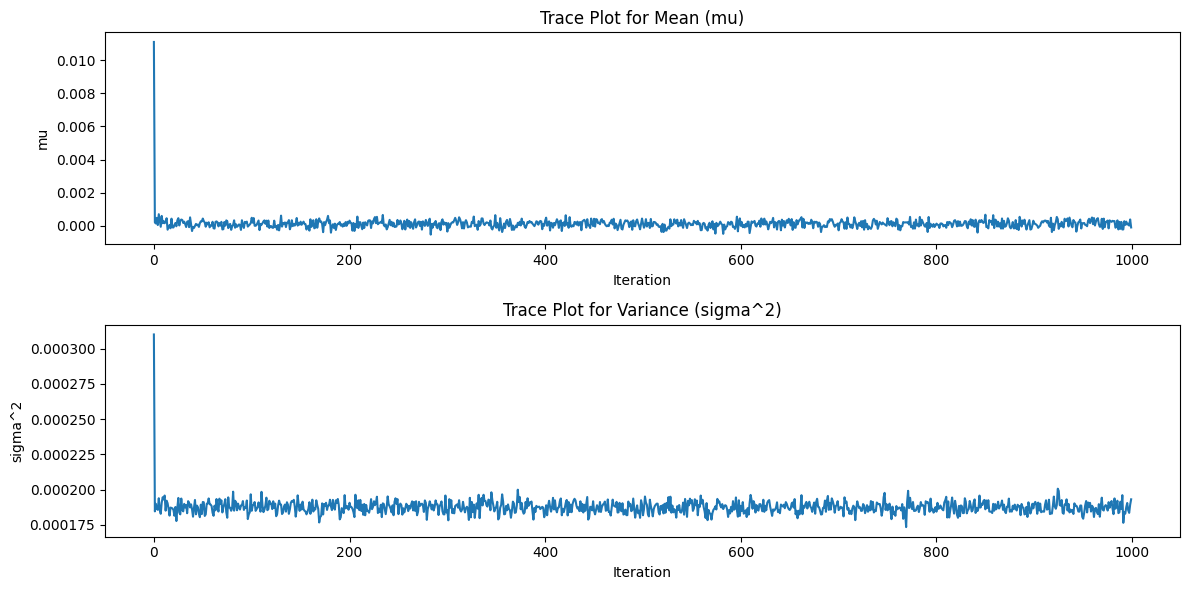

Estimated Mean (mu): 0.00012570784349409626
Estimated Variance (sigma^2): 0.0001875528207415798


In [8]:
# Convergence Diagnostics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plotting mu samples
plt.subplot(2, 1, 1)
plt.plot(mu_samples)
plt.title('Trace Plot for Mean (mu)')
plt.xlabel('Iteration')
plt.ylabel('mu')

# Plotting sigma2 samples
plt.subplot(2, 1, 2)
plt.plot(sigma2_samples)
plt.title('Trace Plot for Variance (sigma^2)')
plt.xlabel('Iteration')
plt.ylabel('sigma^2')

plt.tight_layout()
plt.show()

# Summary Statistics
estimated_mu = np.mean(mu_samples)
estimated_sigma2 = np.mean(sigma2_samples)
print(f'Estimated Mean (mu): {estimated_mu}')
print(f'Estimated Variance (sigma^2): {estimated_sigma2}')

<Figure size 800x400 with 0 Axes>

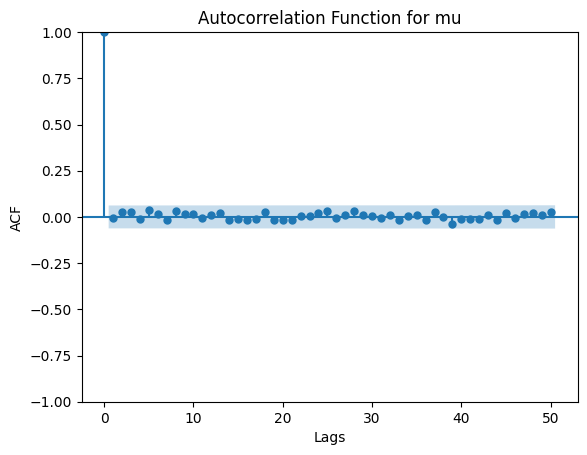

<Figure size 800x400 with 0 Axes>

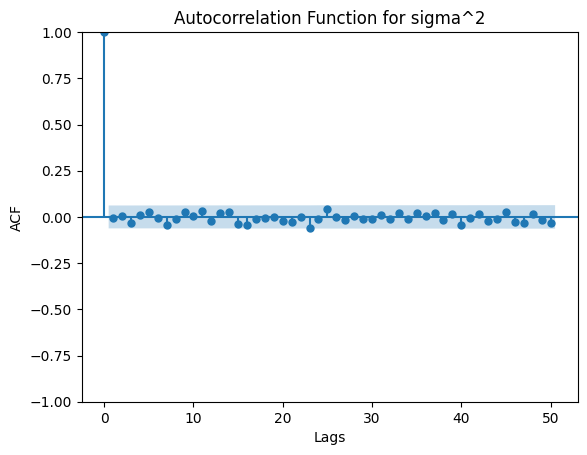

In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Function to plot ACF for a given parameter
def plot_autocorrelation(samples, param_name):
    plt.figure(figsize=(8, 4))
    plot_acf(samples, lags=50, alpha=0.05)
    plt.title(f"Autocorrelation Function for {param_name}")
    plt.xlabel("Lags")
    plt.ylabel("ACF")
    plt.show()

# Plot ACF for mu and sigma^2
plot_autocorrelation(mu_samples, "mu")
plot_autocorrelation(sigma2_samples, "sigma^2")

In [10]:
# Step 5: Calculate VaR and ES for each Gibbs sample
# Define 0.99 confidence interval z-score
confidence_level = 0.99
z_score = stats.norm.ppf(1 - confidence_level)

# Compute VaR and ES for each sample
VaR_samples = []
ES_samples = []

for mu, sigma2 in zip(mu_samples, sigma2_samples):
    VaR = mu + z_score * np.sqrt(sigma2)
    ES = mu - (stats.norm.pdf(z_score) / (1 - confidence_level)) * np.sqrt(sigma2)
    VaR_samples.append(VaR)
    ES_samples.append(ES)

# Convert to numpy arrays for analysis
VaR_samples = np.array(VaR_samples)
ES_samples = np.array(ES_samples)

# Print summary statistics
print(f"VaR (99% CI): Mean={VaR_samples.mean():.5f}, StdDev={VaR_samples.std():.5f}")
print(f"ES (99% CI): Mean={ES_samples.mean():.5f}, StdDev={ES_samples.std():.5f}")

VaR (99% CI): Mean=-0.03173, StdDev=0.00039
ES (99% CI): Mean=-0.03637, StdDev=0.00043


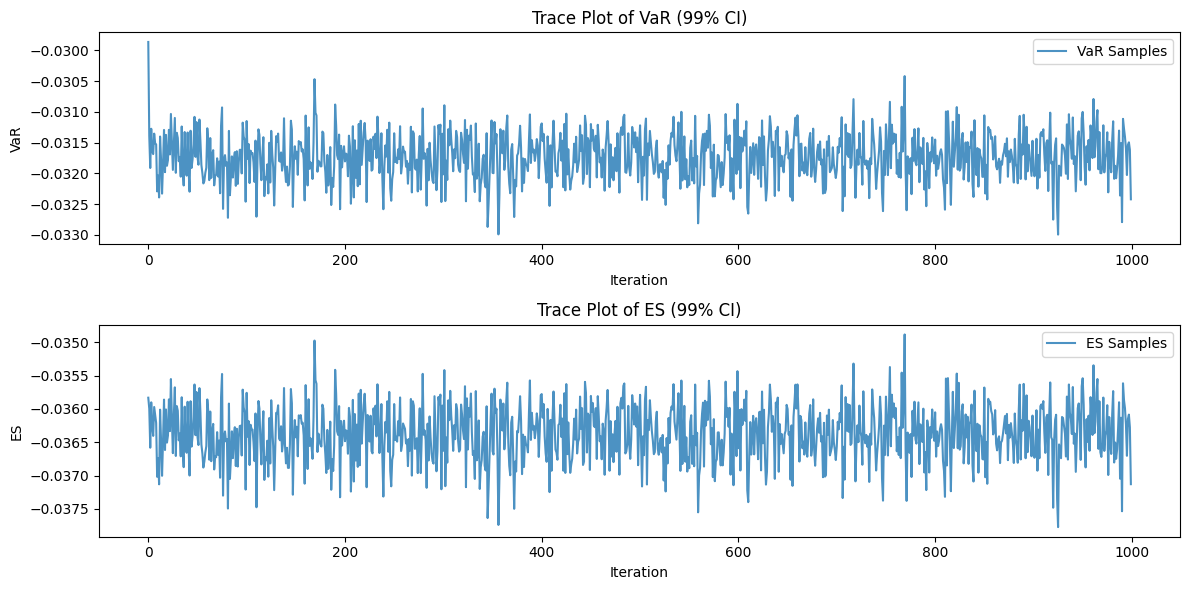

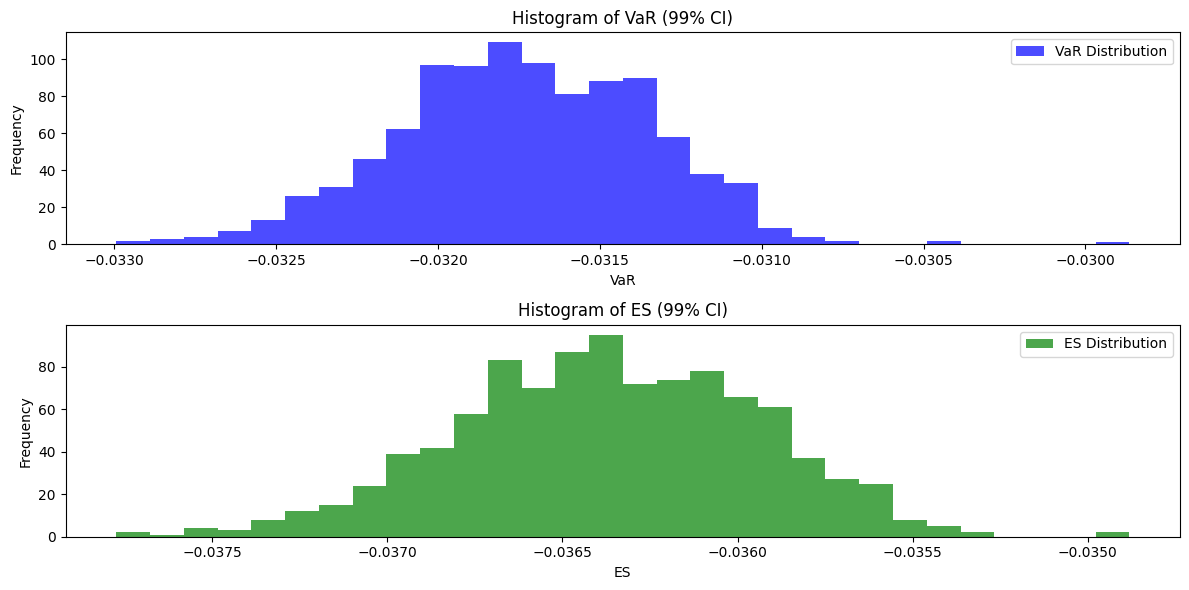

In [11]:
import matplotlib.pyplot as plt

# Trace plots
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(VaR_samples, label='VaR Samples', alpha=0.8)
plt.title("Trace Plot of VaR (99% CI)")
plt.xlabel("Iteration")
plt.ylabel("VaR")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ES_samples, label='ES Samples', alpha=0.8)
plt.title("Trace Plot of ES (99% CI)")
plt.xlabel("Iteration")
plt.ylabel("ES")
plt.legend()

plt.tight_layout()
plt.show()

# Histograms
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.hist(VaR_samples, bins=30, alpha=0.7, label='VaR Distribution', color='blue')
plt.title("Histogram of VaR (99% CI)")
plt.xlabel("VaR")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(ES_samples, bins=30, alpha=0.7, label='ES Distribution', color='green')
plt.title("Histogram of ES (99% CI)")
plt.xlabel("ES")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()